### 1. Load dataset

In [1]:
dataset_base_path = r'/Users/kripik123/Documents/dataset/processedx/selected_fiture_per-dataset/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import describe
from time import time #time stamp for all processing time
from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve, plot_pr_curves, plot_pr_threshold_curves
from ml_ids.prediction import predict_proba_positive, predict_decision_boundary

%matplotlib inline

In [2]:
types = {
    'protocol': 'uint8',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_mean': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_std': 'float32',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_pkts_s': 'float32',
    'fin_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'idle_mean': 'float32',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

## 2. Preprocessing Data

In [3]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, 'dos-*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097149 entries, 0 to 1048573
Data columns (total 34 columns):
 #   Column             Dtype  
---  ------             -----  
 0   protocol           uint8  
 1   flow_duration      int64  
 2   tot_fwd_pkts       uint32 
 3   tot_bwd_pkts       uint32 
 4   totlen_bwd_pkts    uint32 
 5   fwd_pkt_len_mean   float32
 6   fwd_pkt_len_std    float32
 7   bwd_pkt_len_mean   float32
 8   flow_byts_s        float64
 9   flow_pkts_s        float64
 10  flow_iat_std       float32
 11  flow_iat_min       int64  
 12  fwd_iat_tot        int64  
 13  fwd_iat_min        int64  
 14  bwd_iat_tot        uint32 
 15  bwd_iat_mean       float64
 16  bwd_iat_min        uint32 
 17  fwd_psh_flags      uint8  
 18  fwd_urg_flags      uint8  
 19  bwd_pkts_s         float32
 20  fin_flag_cnt       uint8  
 21  rst_flag_cnt       uint8  
 22  psh_flag_cnt       uint8  
 23  ack_flag_cnt       uint8  
 24  urg_flag_cnt       uint8  
 25  down_up_ratio     

In [5]:
#fitur yang nilainya 0 dicari 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

0    fwd_urg_flags
dtype: object

In [6]:
#fitur yang nilainya 0 dihapus
X = X.drop(columns=features_no_variance)

### 2.1. Train / Test split

In order to train and evaluate different models a train/evaluation/test split is created with the ratios of `0.8/0.1/0.1`.  
The split is stratified using the attack category in order to guarantee that all attacks are represented in the training and test set based on their occurences in the dataset.  
To use algorithms expecting categorical values being one-hot-encoded, copies of the training and test data are created (`X_train_oh`, `X_test_oh`) with the feature `protocol` being one-hot-encoded.

In [4]:
## bagi dataset menjadi 80 % untuk training, 10 % untuk testing, 10% untuk evaluasi
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [8]:
## hitung jumlah sampel per kategori di dataset
y.label.value_counts()

Benign                      1442849
DoS attacks-Hulk             461912
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
Name: label, dtype: int64

In [9]:
## hitung jumlah sampel y_train 80%
y_train.label.value_counts()

Benign                      1154279
DoS attacks-Hulk             369530
DoS attacks-SlowHTTPTest     111912
DoS attacks-GoldenEye         33206
DoS attacks-Slowloris          8792
Name: label, dtype: int64

In [10]:
## sampel testing 10%
y_test.label.value_counts()

Benign                      144285
DoS attacks-Hulk             46191
DoS attacks-SlowHTTPTest     13989
DoS attacks-GoldenEye         4151
DoS attacks-Slowloris         1099
Name: label, dtype: int64

In [11]:
## sampel evaluasi 10%
y_eval.label.value_counts()

Benign                      144285
DoS attacks-Hulk             46191
DoS attacks-SlowHTTPTest     13989
DoS attacks-GoldenEye         4151
DoS attacks-Slowloris         1099
Name: label, dtype: int64

In [12]:
## hitung persentasi antara sampel attack dengan benign di y_train
## hasilnya 68% benign, dan sisanya adalah sampel attack

percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    1154279
1     523440
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.6880


## 3. Classifier

#### algoritma yang dipake sesuai Paper Qianru Zhou 
- Random forest
- Gaussian naïve bayes
- Decision tree
- MLP
- K-nn
- Quadratic discriminant analysis

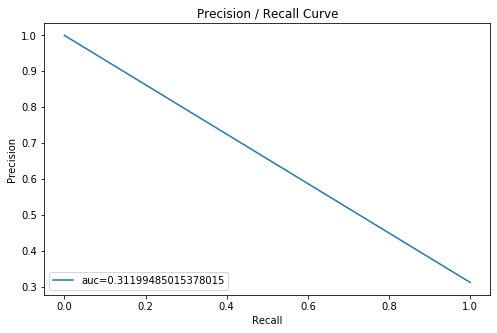

Average PR Score 0.31199485015378015
Time to fit Data Train
0:00:00.36


In [13]:
## 1. baseline clasifier (dummy clasifier)

start_time = time()
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_dummy = predict_proba_positive(cls_dummy, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_dummy)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.688     1.000     0.815    144285
           1      0.000     0.000     0.000     65430

    accuracy                          0.688    209715
   macro avg      0.344     0.500     0.408    209715
weighted avg      0.473     0.688     0.561    209715

Confusion Matrix:


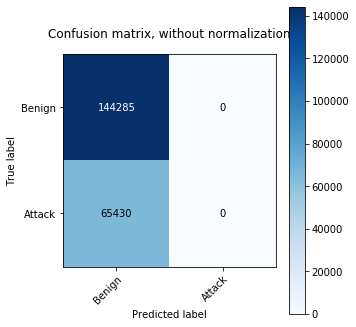

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Hulk,46191,46191,1.0
DoS attacks-SlowHTTPTest,13989,13989,1.0
DoS attacks-GoldenEye,4151,4151,1.0
DoS attacks-Slowloris,1099,1099,1.0


In [14]:
## confusion matrix and missclassification table

pred_val_dummy = cls_dummy.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_dummy)

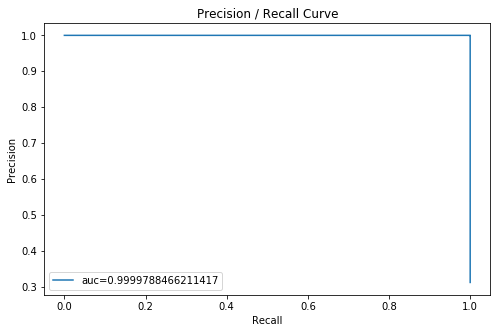

Average PR Score 0.9999788466211417
Time to fit Data Train
0:08:31.16


In [15]:
## 2. RandomForest form scikit-learn with default value
## coba dari source code binary classification

start_time = time()
##cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
##cls_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
cls_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=1)
##cls_forest = RandomForestClassifier()
cls_forest.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_rf = predict_proba_positive(cls_forest, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_rf)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    144285
           1      1.000     1.000     1.000     65430

    accuracy                          1.000    209715
   macro avg      1.000     1.000     1.000    209715
weighted avg      1.000     1.000     1.000    209715

Confusion Matrix:


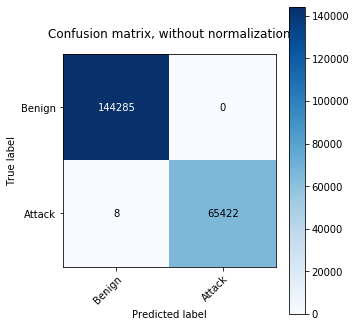

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,8,1099,0.007279


In [16]:
## confusion matrix and missclassification table

pred_val_rf = cls_forest.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_rf)

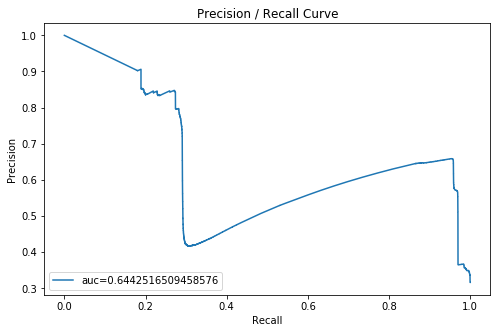

Average PR Score 0.6442516509458576
Time to fit Data Train
0:00:02.04


In [19]:
## 3. Gaussian Naive Bayes
start_time = time()
cls_nb = GaussianNB(priors=None)
cls_nb.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_nb = predict_proba_positive(cls_nb, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_nb)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.972     0.191     0.319    144285
           1      0.356     0.988     0.524     65430

    accuracy                          0.439    209715
   macro avg      0.664     0.589     0.421    209715
weighted avg      0.780     0.439     0.383    209715

Confusion Matrix:


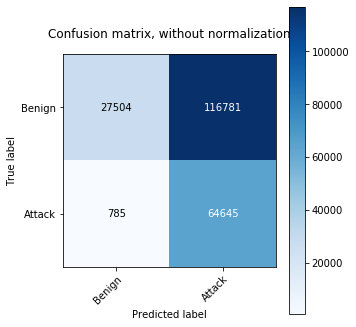

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Benign,116781,144285,0.809377
DoS attacks-GoldenEye,596,4151,0.143580
DoS attacks-Slowloris,55,1099,0.050045
DoS attacks-Hulk,134,46191,0.002901


In [20]:
pred_val_nb = cls_nb.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_nb)

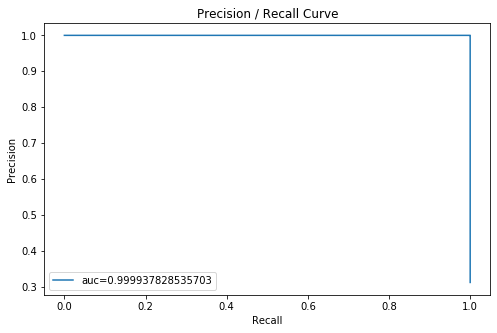

Average PR Score 0.999937828535703
Time to fit Data Train
0:00:38.07


In [21]:
## 4. Decission Tree

start_time = time()
##cls_dt = DecisionTreeClassifier(max_depth=5,criterion="entropy")
cls_dt = DecisionTreeClassifier(splitter='best', criterion='gini', min_samples_split=2, min_samples_leaf=1)
cls_dt.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_dt = predict_proba_positive(cls_dt, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_dt)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    144285
           1      1.000     1.000     1.000     65430

    accuracy                          1.000    209715
   macro avg      1.000     1.000     1.000    209715
weighted avg      1.000     1.000     1.000    209715

Confusion Matrix:


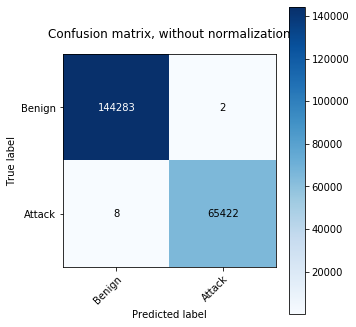

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,8,1099,0.007279
Benign,2,144285,0.000014


In [22]:
pred_val_dt = cls_dt.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_dt)

In [ ]:
## 5. MLP
from sklearn.neural_network import MLPClassifier

start_time = time()
##cls_mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
cls_mlp= MLPClassifier(hidden_layer_sizes=(100,),learning_rate_init=0.001,activation='relu',solver='adam',alpha=0.0001,batch_size='auto',power_t=0.5,max_iter=200)
cls_mlp.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_mlp = predict_proba_positive(cls_mlp, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_mlp)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.688     1.000     0.815    144285
           1      0.000     0.000     0.000     65430

    accuracy                          0.688    209715
   macro avg      0.344     0.500     0.408    209715
weighted avg      0.473     0.688     0.561    209715

Confusion Matrix:


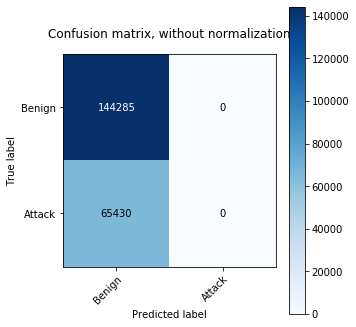

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Hulk,46191,46191,1.0
DoS attacks-SlowHTTPTest,13989,13989,1.0
DoS attacks-GoldenEye,4151,4151,1.0
DoS attacks-Slowloris,1099,1099,1.0


In [45]:
pred_val_mlp = cls_mlp.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_mlp)

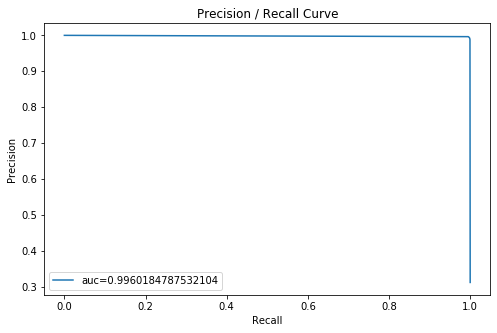

Average PR Score 0.9960184787532104
Time to fit Data Train
0:07:48.28


In [47]:
## 6. KNN

start_time = time()
cls_knn = KNeighborsClassifier(n_neighbors=5, leaf_size=30, p=2, metric='minkowski')
cls_knn.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_knn = predict_proba_positive(cls_knn, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_knn)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.997     0.998    144285
           1      0.993     0.998     0.996     65430

    accuracy                          0.997    209715
   macro avg      0.996     0.998     0.997    209715
weighted avg      0.997     0.997     0.997    209715

Confusion Matrix:


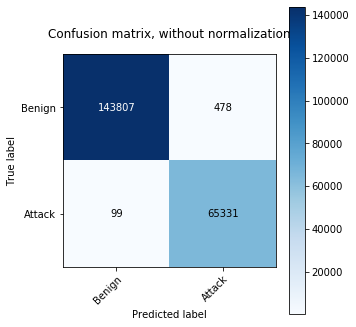

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,21,1099,0.019108
Benign,478,144285,0.003313
DoS attacks-GoldenEye,11,4151,0.002650
DoS attacks-Hulk,66,46191,0.001429
DoS attacks-SlowHTTPTest,1,13989,0.000071


In [48]:
pred_val_knn = cls_knn.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_knn)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


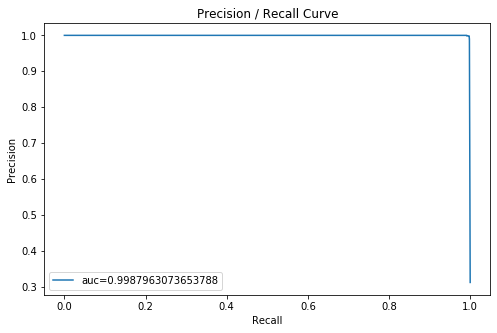

Average PR Score 0.9987963073653788
Time to fit Data Train
0:00:05.09


In [50]:
## 7. QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

start_time = time()
cls_qda = QDA(priors=None, reg_param=0.0)
cls_qda.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_qda = predict_proba_positive(cls_qda, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_qda)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.996     1.000     0.998    144285
           1      1.000     0.991     0.996     65430

    accuracy                          0.997    209715
   macro avg      0.998     0.996     0.997    209715
weighted avg      0.997     0.997     0.997    209715

Confusion Matrix:


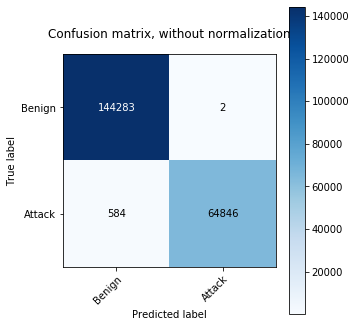

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,161,1099,0.146497
DoS attacks-GoldenEye,219,4151,0.052758
DoS attacks-Hulk,204,46191,0.004416
Benign,2,144285,0.000014


In [51]:
pred_val_qda = cls_qda.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_qda)

### algoritma lainnya misalnya Log regresion --> tapi algor ini belum ada di paper IDS manapun
- Gozde Karatas (Knn, Random Forest, Gradient Boosting, Adaboost, Decision Tree, LDA)

In [71]:
scaler = StandardScaler()
scaler.fit(X_train_oh)

StandardScaler(copy=True, with_mean=True, with_std=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


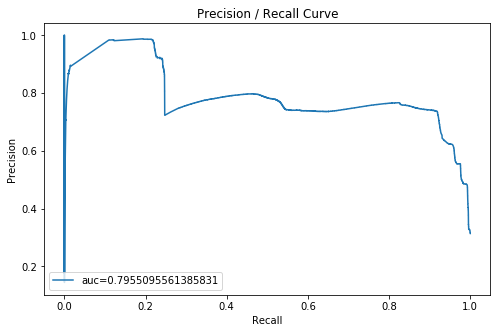

Average PR Score 0.7955095561385831
Time to fit Data Train
0:00:18.66


In [74]:
## 8. Log Regression from scikit-learn with default value
start_time = time()
##cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr= LogisticRegression(penalty='l2',solver='lbfgs',max_iter=100,verbose=0)
##cls_lr.fit(scaler.transform(X_train_oh), y_train.label_is_attack)
cls_lr.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_lr = predict_proba_positive(cls_lr, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_lr)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.737     0.958     0.833    144285
           1      0.729     0.247     0.369     65430

    accuracy                          0.736    209715
   macro avg      0.733     0.603     0.601    209715
weighted avg      0.735     0.736     0.689    209715

Confusion Matrix:


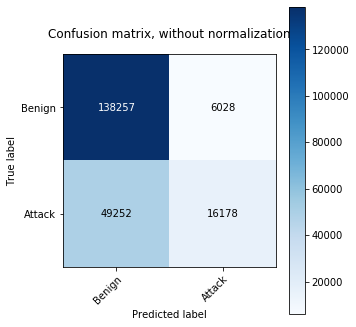

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Hulk,46186,46191,0.999892
DoS attacks-GoldenEye,2663,4151,0.641532
DoS attacks-Slowloris,403,1099,0.366697
Benign,6028,144285,0.041778


In [75]:
pred_val_lr = cls_lr.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_lr)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


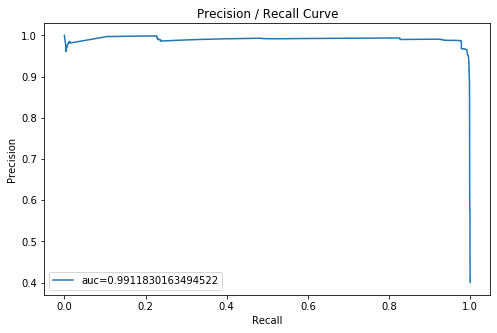

Average PR Score 0.9911830163494522
Time to fit Data Train
0:00:14.78


In [76]:
## 8.2 Log Regression from scikit-learn with standard scaler
start_time = time()
##cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr2= LogisticRegression(penalty='l2',solver='lbfgs',max_iter=100,verbose=0)
cls_lr2.fit(scaler.transform(X_train_oh), y_train.label_is_attack)
##cls_lr.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_lr2 = predict_proba_positive(cls_lr2, scaler.transform(X_eval_oh))
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_lr2)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.994     0.985     0.989    144285
           1      0.967     0.987     0.977     65430

    accuracy                          0.985    209715
   macro avg      0.980     0.986     0.983    209715
weighted avg      0.986     0.985     0.985    209715

Confusion Matrix:


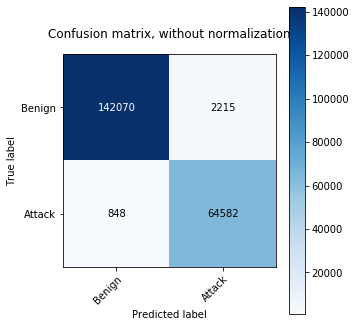

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-GoldenEye,649,4151,0.156348
DoS attacks-Slowloris,35,1099,0.031847
Benign,2215,144285,0.015352
DoS attacks-Hulk,164,46191,0.003550


In [78]:
pred_val_lr2 = cls_lr2.predict(scaler.transform(X_eval_oh))
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_lr2)

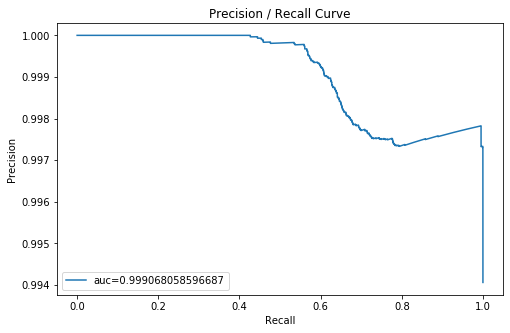

Average PR Score 0.999068058596687
Time to fit Data Train
0:03:38.97


In [84]:
## 5. MLP
from sklearn.neural_network import MLPClassifier

start_time = time()
##cls_mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
cls_mlp2= MLPClassifier(hidden_layer_sizes=(100,),learning_rate_init=0.001,activation='relu',solver='adam',alpha=0.0001,batch_size='auto',power_t=0.5,max_iter=200) 
cls_mlp2.fit(scaler.transform(X_train_oh), y_train.label_is_attack)

pred_val_proba_mlp2 = predict_proba_positive(cls_mlp2, scaler.transform(X_eval_oh))
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_mlp2)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.999     0.999    144285
           1      0.997     1.000     0.999     65430

    accuracy                          0.999    209715
   macro avg      0.999     0.999     0.999    209715
weighted avg      0.999     0.999     0.999    209715

Confusion Matrix:


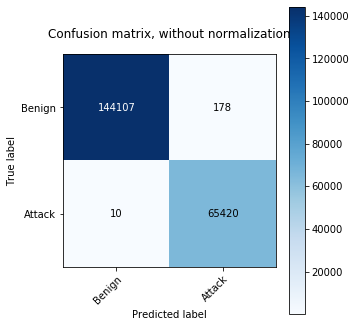

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,10,1099,0.009099
Benign,178,144285,0.001234


In [85]:
pred_val_mlp2 = cls_mlp2.predict(scaler.transform(X_eval_oh))
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_mlp2)

In [7]:
## 9. Gradient Boosting form CatBoost --> opensource 
train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [9]:
start_time = time()
minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

cls_cb.fit(train_pool, eval_set=eval_pool)
pred_val_proba_cb = predict_proba_positive(cls_cb, eval_pool)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_cb)

end_time=time()
total=end_time-start_time

CatBoostError: catboost/libs/train_lib/train_model.cpp:916: Can't load GPU learning library. Module was not compiled or driver  is incompatible with package. Please install latest NVDIA driver and check again

In [ ]:
print_report('Train', cls_cb, train_pool, y_train.label_is_attack, cls_cb.predict(train_pool))
print_report('Eval', cls_cb, eval_pool, y_eval.label_is_attack, cls_cb.predict(eval_pool), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

## 6. Model Comparison

The following plot illustrates the Precision / Recall curves of the different models.

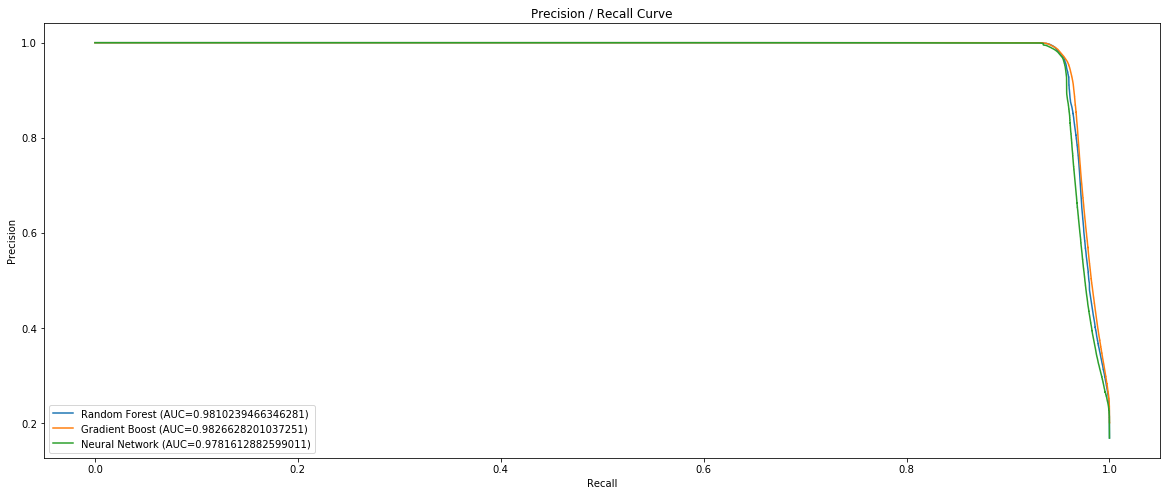

In [68]:
plot_pr_curves(y_val.label_is_attack, 
               {
                   'Random Forest': pred_val_proba_rf,
                   'Gradient Boost': pred_val_proba_gb,
                   'Neural Network': pred_val_proba_dl
               }, 
               size=(20, 8))

Comparing the results, we observe similar performance metrics across the different models.    

Both the Random Forest and Gradient Boosted Tree models perform better than the Neural Network though, achieving a slighty higher PR score, precision and recall.

Overall, the Gradient Boosted Tree model yields the best performance, having the highest PR score and recall in respect to the positive class, with only a slightly lower precision compared to the Random Forest model. Consequently, this model also returns the lowest amount of false-negatives. 

|Model|PR Score|Precision Positive|Recall Positive|False-Positives|False-Negatives|
|---|---|---|---|---|---|
|Random Forest         |0.98102|**0.967**|0.955|**8820**|12322|
|Gradient Boosted Trees|**0.98266**|0.964|**0.957**|9784|**11748**|
|Deep Neural Network   |0.97816|**0.967**|0.954|8966|12629|

We choose to use the Gradient Bosted Tree model going forward, as it achieves the best overall performance.

### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|
|z|0.00|0.00|0.00|0|0|

Gradient Boost performed best of all models and will be used as the final estimator.

## 7. Performance on Test Set

In this section we use our best performing model to make predictions on the test set in order to obtain an unbiased performance estimate of the model.

The results demonstrate that the performance on the test set is very similar to the performance on the validation set, suggesting that we have built a model that generalizes well to unseen data, provided that the data has similar statistical characteristics as the test set.

In [ ]:
pred_test_gb = clf_gb.predict(X_test)
print_binary_performance(y_test, y_test.label_is_attack, pred_test_gb)